<center><h1>Modelling</h1></center>
Making some changes in the base U-Net:<br>
<ul><li> Adding ScSe blocks
    <li>Hypercolumns
<li>Adding a second channel to the input img with values equal to that of depth</ul>

In [1]:
#importing libraries
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import tensorflow.keras
import imgaug.augmenters as iaa
import datetime
import sklearn.model_selection
# tf.config.list_physical_devices('GPU')
%load_ext tensorboard
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, MaxPooling2D, GlobalMaxPool2D, Conv2D, Conv2DTranspose, concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense,add, Permute, Conv2D,multiply
from tensorflow.keras import backend as K

data=pd.read_csv("dataset.csv")

def Kaggle_IoU_Precision(y_true, y_pred, threshold=0.5):
    y_pred = K.squeeze(tf.cast((y_pred > threshold),tf.int32), -1)
    y_true = K.cast(y_true[..., 0], K.floatx())
    y_pred = K.cast(y_pred, K.floatx())
    truth_areas = K.sum(y_true, axis=[1, 2])
    pred_areas = K.sum(y_pred, axis=[1, 2])
    intersection = K.sum(y_true * y_pred, axis=[1, 2])
    union = K.clip(truth_areas + pred_areas - intersection, 1e-9, 128 * 128)
    check = K.map_fn(lambda x: K.equal(x, 0), truth_areas + pred_areas, dtype=tf.bool)
    p = intersection / union
    iou = K.switch(check, p + 1., p)

    prec = K.map_fn(lambda x: K.mean(K.greater(x, np.arange(0.5, 1.0, 0.05))), iou, dtype=tf.float32)
    prec_iou = K.mean(prec)
    return prec_iou
    
kaggle_iou_score=Kaggle_IoU_Precision
iou_score=tf.keras.metrics.BinaryIoU()

### Splitting data

In [51]:
train,validation=sklearn.model_selection.train_test_split(data,test_size=0.1)

### Image Datagenerator

In [52]:
#datagenerator
def random_in_range(lower_limit,upper_limit):
    number=lower_limit+(np.random.rand(1)[0]*(upper_limit-lower_limit))
    return number

def clean_mask(arr):
    temp=np.nonzero(arr)
        
    for i in range(temp[0].shape[0]):
        arr[temp[0][i],temp[1][i]]=1
    return arr


class Dataset:
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, file_path,mask_path,depths):
        
        self.iids = file_path
        self.mids = mask_path
        self.depths=depths
        # the paths of images
        self.images_fps   = [i for i in self.iids]
        # the paths of segmentation images
        self.masks_fps    = [i for i in self.mids]
        self.depths       = [i for i in self.depths]
        # giving labels for each class

    def __getitem__(self, i):
        
        # read data
        image=cv2.imread(self.images_fps[i],cv2.IMREAD_GRAYSCALE)
        image_mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)

        a = np.random.uniform()
        if a<0.1:
            aug=iaa.blur.GaussianBlur(random_in_range(0,2.5))
            image,image_mask=aug.augment(images=[image,image_mask])
        elif a<0.25:
            aug = iaa.Fliplr(1)
            image,image_mask=aug.augment(images=[image,image_mask])
        elif a<0.4:
            aug = iaa.Affine(scale={"x": random_in_range(1,1.5), "y":random_in_range(1,1.5)})
            image,image_mask=aug.augment(images=[image,image_mask])
            
        elif a<0.55:
            aug = iaa.Affine(rotate=random_in_range(0,360))
            image,image_mask=aug.augment(images=[image,image_mask])
            
        elif a<0.70:
            aug = iaa.Affine(shear=random_in_range(-16,16))
            image,image_mask=aug.augment(images=[image,image_mask])
            
        elif a<0.85:
            aug=iaa.PiecewiseAffine(scale=random_in_range(0.01, 0.05))
            image,image_mask=aug.augment(images=[image,image_mask])

        else:
            aug=iaa.GammaContrast(random_in_range(0.5, 2.0))
            image,image_mask=aug.augment(images=[image,image_mask])
            
        image = cv2.copyMakeBorder(image, 13, 14, 13, 14, cv2.BORDER_CONSTANT,value=[0,0,0])
        image_mask = cv2.copyMakeBorder(image_mask,13, 14, 13, 14, cv2.BORDER_CONSTANT,value=[0,0,0])
        
        image=np.stack([image,np.full((128,128),self.depths[i])],axis=2)
        
        image_mask=clean_mask(image_mask)

        return image, image_mask
        
    def __len__(self):
        return len(self.iids)
       
class Test_Dataset:
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, file_path,mask_path,depths):
        
        self.iids = file_path
        self.mids = mask_path
        self.depths=depths
        # the paths of images
        self.images_fps   = [i for i in self.iids]
        # the paths of segmentation images
        self.masks_fps    = [i for i in self.mids]
        self.depths       = [i for i in self.depths]
        # giving labels for each class

    def __getitem__(self, i):
        
        # read data
        image=cv2.imread(self.images_fps[i],cv2.IMREAD_GRAYSCALE)
        image_mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)

        image = cv2.copyMakeBorder(image, 13, 14, 13, 14, cv2.BORDER_CONSTANT,value=[0,0,0])
        image_mask = cv2.copyMakeBorder(image_mask,13, 14, 13, 14, cv2.BORDER_CONSTANT,value=[0,0,0])

        # image = cv2.resize(image,(128,128),interpolation=cv2.INTER_NEAREST)
        # image_mask = cv2.resize(image_mask,(128,128),interpolation=cv2.INTER_NEAREST)
        
        image_mask=clean_mask(image_mask)
        
        image=np.stack([image,np.full((128,128),self.depths[i])],axis=2)

        return image, image_mask
        
    def __len__(self):
        return len(self.iids)
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

train_dataset = Dataset(train['img_path'],train['mask_path'],train['depth'])
val_dataset = Test_Dataset(validation['img_path'],validation['mask_path'],validation['depth'])

train_dataloader = Dataloder(train_dataset, batch_size=8, shuffle=True)
val_dataloader = Dataloder(val_dataset, batch_size=8, shuffle=False)

print(train_dataloader[0][0].shape)
print(val_dataloader[0][0].shape)
# plt.imshow(train_dataloader[0][0][0])

(8, 128, 128, 2)
(8, 128, 128, 2)


### ScSe Blocks

In [8]:
def squeeze_excite_block(input, ratio=16):
    ''' Create a channel-wise squeeze-excite block
    Args:
        input: input tensor
        filters: number of output filters
    Returns: a keras tensor
    References
    -   [Squeeze and Excitation Networks](https://arxiv.org/abs/1709.01507)
    '''
    init = input
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    if K.image_data_format() == 'channels_first':
        se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x


def spatial_squeeze_excite_block(input):
    ''' Create a spatial squeeze-excite block
    Args:
        input: input tensor
    Returns: a keras tensor
    References
    -   [Concurrent Spatial and Channel Squeeze & Excitation in Fully Convolutional Networks](https://arxiv.org/abs/1803.02579)
    '''

    se = Conv2D(1, (1, 1), activation='sigmoid', use_bias=False,
                kernel_initializer='he_normal')(input)

    x = multiply([input, se])
    return x


def channel_spatial_squeeze_excite(input, ratio=16):
    ''' Create a spatial squeeze-excite block
    Args:
        input: input tensor
        filters: number of output filters
    Returns: a keras tensor
    References
    -   [Squeeze and Excitation Networks](https://arxiv.org/abs/1709.01507)
    -   [Concurrent Spatial and Channel Squeeze & Excitation in Fully Convolutional Networks](https://arxiv.org/abs/1803.02579)
    '''

    cse = squeeze_excite_block(input, ratio)
    sse = spatial_squeeze_excite_block(input)

    x = add([cse, sse])
    return x

### U-Net Model

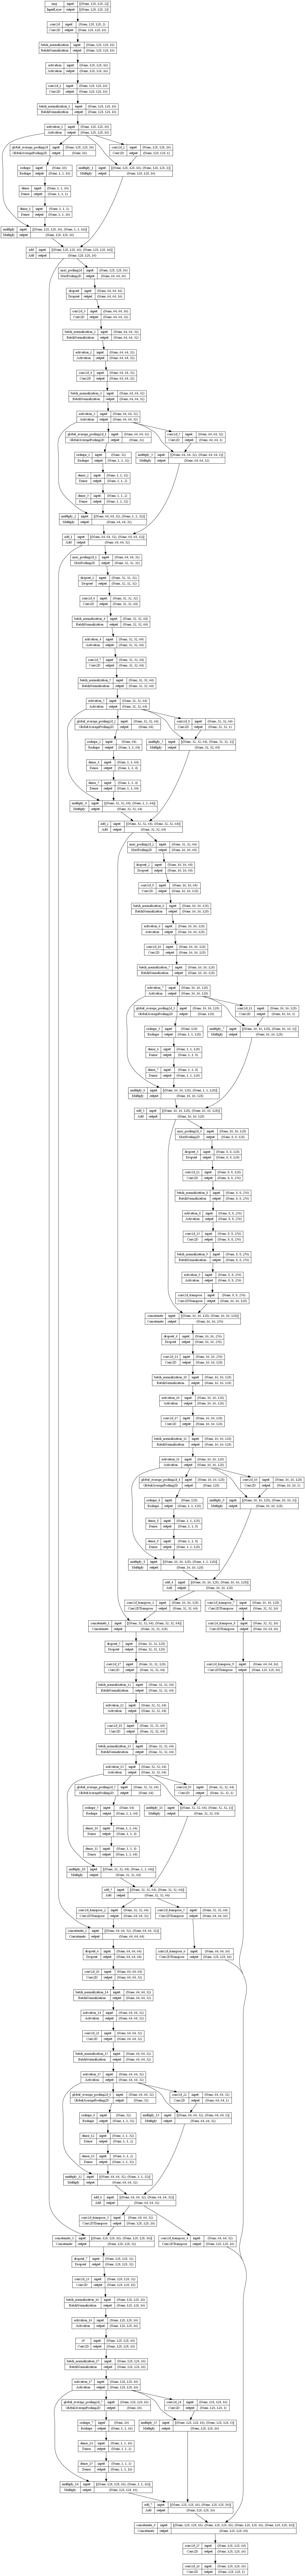

In [9]:
# I tried to make it as simple as possible, I think you can understand the architecture just by looking at the code below
def UNet(input_img):

    c1 = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(input_img)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    
    c1 = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1= channel_spatial_squeeze_excite(c1)
    
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)
#-----------------------------------------------------------------------------------------------------------------    
    
    c2 = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    
    c2 = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2= channel_spatial_squeeze_excite(c2)
    
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2) 
#-----------------------------------------------------------------------------------------------------------------    
    
    c3 = Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    
    c3 = Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3= channel_spatial_squeeze_excite(c3)
    
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.1)(p3) 
    
#-----------------------------------------------------------------------------------------------------------------    
    
    c4 = Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    
    c4 = Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4= channel_spatial_squeeze_excite(c4)
    
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.1)(p4) 
    
#-----------------------------------------------------------------------------------------------------------------    
    
    c5 = Conv2D(256, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    
    c5 = Conv2D(256, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    
#------UMSAMPLE STARTS---------------------------------------------------------------------------------------------

    u6 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    
    c6 = Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    
    c6 = Conv2D(128, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = channel_spatial_squeeze_excite(c6)
#---------------------------------------------------------------------------------------------------

    u7 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    
    c7 = Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    
    c7 = Conv2D(64, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = channel_spatial_squeeze_excite(c7)
#---------------------------------------------------------------------------------------------------

    u8 = Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    
    c8 = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

    c8 = Conv2D(32, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8= channel_spatial_squeeze_excite(c8)
#---------------------------------------------------------------------------------------------------

    u9 = Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    
    c9 = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    
    c9 = Conv2D(16, kernel_size = (3,3), kernel_initializer = 'he_normal', padding = 'same',name="c9")(c9)
    c9 = BatchNormalization()(c9)
    c9 = Activation('relu')(c9)
    c9= channel_spatial_squeeze_excite(c9)
    
    upsample_c8=Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(c8)
    upsample_c7=Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(c7)
    upsample_c7=Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(upsample_c7)
    upsample_c6=Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(c6)
    upsample_c6=Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(upsample_c6)
    upsample_c6=Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same')(upsample_c6)

    
    hypercolumns=concatenate([c9,upsample_c8,upsample_c7,upsample_c6])
    final_conv = Conv2D(16, (3, 3),padding="same")(hypercolumns)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(final_conv)
 
    
    model = Model(input_img, outputs)
    return model
input_img = Input((128, 128, 2), name='img')
model = UNet(input_img)
tf.keras.utils.plot_model(model,show_shapes=True)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  304         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 32)  0           ['add_1[0][0]']                  
                                                                                                  
 dropout_1 (Dropout)            (None, 32, 32, 32)   0           ['max_pooling2d_1[0][0]']        
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 64)   18496       ['dropout_1[0][0]']              
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 32, 32, 64)  256         ['conv2d_6[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activatio

 conv2d_12 (Conv2D)             (None, 8, 8, 256)    295168      ['dropout_3[0][0]']              
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 8, 8, 256)   1024        ['conv2d_12[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 8, 8, 256)    0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_13 (Conv2D)             (None, 8, 8, 256)    590080      ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 8, 8, 256)   1024        ['conv2d_13[0][0]']              
 rmalizati

                                                                 ]']                              
                                                                                                  
 dense_10 (Dense)               (None, 1, 1, 4)      256         ['reshape_5[0][0]']              
                                                                                                  
 dense_11 (Dense)               (None, 1, 1, 64)     256         ['dense_10[0][0]']               
                                                                                                  
 conv2d_19 (Conv2D)             (None, 32, 32, 1)    64          ['activation_13[0][0]']          
                                                                                                  
 multiply_10 (Multiply)         (None, 32, 32, 64)   0           ['activation_13[0][0]',          
                                                                  'dense_11[0][0]']               
          

                                                                                                  
 activation_17 (Activation)     (None, 128, 128, 16  0           ['batch_normalization_17[0][0]'] 
                                )                                                                 
                                                                                                  
 global_average_pooling2d_7 (Gl  (None, 16)          0           ['activation_17[0][0]']          
 obalAveragePooling2D)                                                                            
                                                                                                  
 reshape_7 (Reshape)            (None, 1, 1, 16)     0           ['global_average_pooling2d_7[0][0
                                                                 ]']                              
                                                                                                  
 dense_14 

### Callbacks

In [55]:
# rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

def scheduler(epoch, lr):
    if lr<=0.0001:
      return lr
    return lr*0.955

save_model = tf.keras.callbacks.ModelCheckpoint(filepath="model_save/16endconvep{epoch:03d}-val_loss{val_loss:.3f}.h5"\
                                        , monitor='val_loss',  verbose=1, save_best_only=True, mode='min',save_freq='epoch')

percent_5_decrease = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Losses

In [11]:
def tf_lovasz_grad(gt_sorted):
    """
    Code from Maxim Berman's GitHub repo for Lovasz.

    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard
    
def lovasz_hinge_flat(y_true, y_pred):
        # modified from Maxim Berman's GitHub repo tf implementation for Lovasz
        eps = 1e-12  # for stability
        y_pred = K.clip(y_pred, eps, 1-eps)
        logits = K.log(y_pred/(1-y_pred))
        logits = tf.reshape(logits, (-1,))
        y_true = tf.reshape(y_true, (-1,))
        y_true = tf.cast(y_true, logits.dtype)
        signs = 2. * y_true - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0],
                                          name="descending_sort")
        gt_sorted = tf.gather(y_true, perm)
        grad = tf_lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted),
                            tf.stop_gradient(grad),
                            1, name="loss_non_void")
        return loss
def jaccard_distance(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """
    y_true=tf.cast(y_true,tf.float32)
    # print(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1,2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1,2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd =  (1 - jac) * smooth
    return tf.reduce_mean(jd)

### 150 Epochs with Binary Cross Entropy loss

In [34]:
model.compile(optimizer=Adam(0.001), loss="binary_crossentropy", metrics=[iou_score,"accuracy"])

In [35]:
model.fit(train_dataloader,epochs=50,steps_per_epoch=len(train_dataloader)//2,validation_data=val_dataloader,callbacks=[tensorboard_callback,percent_5_decrease,save_model])

Epoch 1/50
900/900 [==============================] - ETA: 0s - loss: 0.2682 - binary_io_u: 0.5975 - accuracy: 0.8818
Epoch 1: val_loss did not improve from 0.25363
900/900 [==============================] - 44s 39ms/step - loss: 0.2682 - binary_io_u: 0.5975 - accuracy: 0.8818 - val_loss: 0.3030 - val_binary_io_u: 0.4311 - val_accuracy: 0.8369 - lr: 9.5500e-04
Epoch 2/50
899/900 [============================>.] - ETA: 0s - loss: 0.2417 - binary_io_u: 0.6756 - accuracy: 0.9042
Epoch 2: val_loss improved from 0.25363 to 0.24536, saving model to model_save/ep002-val_loss0.245.h5
900/900 [==============================] - 34s 38ms/step - loss: 0.2418 - binary_io_u: 0.6752 - accuracy: 0.9041 - val_loss: 0.2454 - val_binary_io_u: 0.6966 - val_accuracy: 0.8855 - lr: 9.1203e-04
Epoch 3/50
899/900 [============================>.] - ETA: 0s - loss: 0.2173 - binary_io_u: 0.7186 - accuracy: 0.9163
Epoch 3: val_loss improved from 0.24536 to 0.22127, saving model to model_save/ep003-val_loss0.221.h5

In [36]:
model.fit(train_dataloader,initial_epoch=50,epochs=100,steps_per_epoch=len(train_dataloader)//2,validation_data=val_dataloader,callbacks=[tensorboard_callback,percent_5_decrease,save_model])

Epoch 51/100
899/900 [============================>.] - ETA: 0s - loss: 0.0813 - binary_io_u: 0.8916 - accuracy: 0.9704
Epoch 51: val_loss did not improve from 0.10104
900/900 [==============================] - 35s 39ms/step - loss: 0.0812 - binary_io_u: 0.8916 - accuracy: 0.9704 - val_loss: 0.1066 - val_binary_io_u: 0.8668 - val_accuracy: 0.9611 - lr: 9.5537e-05
Epoch 52/100
899/900 [============================>.] - ETA: 0s - loss: 0.0855 - binary_io_u: 0.8801 - accuracy: 0.9670
Epoch 52: val_loss did not improve from 0.10104
900/900 [==============================] - 36s 40ms/step - loss: 0.0855 - binary_io_u: 0.8799 - accuracy: 0.9669 - val_loss: 0.1015 - val_binary_io_u: 0.8737 - val_accuracy: 0.9626 - lr: 9.5537e-05
Epoch 53/100
899/900 [============================>.] - ETA: 0s - loss: 0.0846 - binary_io_u: 0.8836 - accuracy: 0.9687
Epoch 53: val_loss improved from 0.10104 to 0.10057, saving model to model_save/ep053-val_loss0.101.h5
900/900 [==============================] - 35

In [20]:
#loading best model
model.load_weights("16endconv/ep086-val_loss0.099.h5")

## changing loss to jaccard for 350 epochs

In [17]:
#changing loss to jaccard
model.compile(optimizer=Adam(0.001), loss=jaccard_distance, metrics=[iou_score,"accuracy"])
model.fit(train_dataloader,epochs=50,steps_per_epoch=len(train_dataloader)//16,validation_data=val_dataloader,callbacks=[tensorboard_callback,percent_5_decrease,save_model])

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 27.0858 - binary_io_u: 0.8375 - accuracy: 0.9509
Epoch 1: val_loss improved from inf to 27.32112, saving model to model_save\16endconvep001-val_loss27.321.h5
14/14 [==============================] - 11s 411ms/step - loss: 27.0858 - binary_io_u: 0.8375 - accuracy: 0.9509 - val_loss: 27.3211 - val_binary_io_u: 0.7807 - val_accuracy: 0.9291 - lr: 9.5500e-04
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 26.9580 - binary_io_u: 0.7843 - accuracy: 0.9485
Epoch 2: val_loss did not improve from 27.32112
14/14 [==============================] - 4s 304ms/step - loss: 26.9580 - binary_io_u: 0.7843 - accuracy: 0.9485 - val_loss: 28.1023 - val_binary_io_u: 0.7478 - val_accuracy: 0.9173 - lr: 9.1203e-04
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 22.1347 - binary_io_u: 0.8404 - accuracy: 0.9507
Epoch 3: val_loss did not improve from 27.32112
14/14 [==============================] - 4s 319

Epoch 22/50
14/14 [==============================] - ETA: 0s - loss: 18.8058 - binary_io_u: 0.8559 - accuracy: 0.9575
Epoch 22: val_loss did not improve from 14.66340
14/14 [==============================] - 4s 308ms/step - loss: 18.8058 - binary_io_u: 0.8559 - accuracy: 0.9575 - val_loss: 15.2249 - val_binary_io_u: 0.8800 - val_accuracy: 0.9668 - lr: 3.6314e-04
Epoch 23/50
14/14 [==============================] - ETA: 0s - loss: 21.3025 - binary_io_u: 0.8366 - accuracy: 0.9532
Epoch 23: val_loss did not improve from 14.66340
14/14 [==============================] - 4s 307ms/step - loss: 21.3025 - binary_io_u: 0.8366 - accuracy: 0.9532 - val_loss: 16.1501 - val_binary_io_u: 0.8712 - val_accuracy: 0.9639 - lr: 3.4680e-04
Epoch 24/50
14/14 [==============================] - ETA: 0s - loss: 18.1605 - binary_io_u: 0.8658 - accuracy: 0.9606
Epoch 24: val_loss did not improve from 14.66340
14/14 [==============================] - 4s 313ms/step - loss: 18.1605 - binary_io_u: 0.8658 - accuracy

Epoch 44/50
14/14 [==============================] - ETA: 0s - loss: 17.2627 - binary_io_u: 0.8654 - accuracy: 0.9623
Epoch 44: val_loss did not improve from 13.66882
14/14 [==============================] - 4s 302ms/step - loss: 17.2627 - binary_io_u: 0.8654 - accuracy: 0.9623 - val_loss: 14.3140 - val_binary_io_u: 0.8919 - val_accuracy: 0.9704 - lr: 1.3187e-04
Epoch 45/50
14/14 [==============================] - ETA: 0s - loss: 15.4604 - binary_io_u: 0.8873 - accuracy: 0.9698
Epoch 45: val_loss did not improve from 13.66882
14/14 [==============================] - 4s 316ms/step - loss: 15.4604 - binary_io_u: 0.8873 - accuracy: 0.9698 - val_loss: 14.0670 - val_binary_io_u: 0.8941 - val_accuracy: 0.9712 - lr: 1.2594e-04
Epoch 46/50
14/14 [==============================] - ETA: 0s - loss: 15.5426 - binary_io_u: 0.8827 - accuracy: 0.9701
Epoch 46: val_loss did not improve from 13.66882
14/14 [==============================] - 4s 301ms/step - loss: 15.5426 - binary_io_u: 0.8827 - accuracy

In [18]:
model.fit(train_dataloader,initial_epoch=50,epochs=150,steps_per_epoch=len(train_dataloader)//16,validation_data=val_dataloader,callbacks=[tensorboard_callback,percent_5_decrease,save_model])

Epoch 51/150
14/14 [==============================] - ETA: 0s - loss: 14.0414 - binary_io_u: 0.8667 - accuracy: 0.9630
Epoch 51: val_loss did not improve from 13.46493
14/14 [==============================] - 5s 338ms/step - loss: 14.0414 - binary_io_u: 0.8667 - accuracy: 0.9630 - val_loss: 13.7082 - val_binary_io_u: 0.8987 - val_accuracy: 0.9729 - lr: 9.5537e-05
Epoch 52/150
14/14 [==============================] - ETA: 0s - loss: 16.4187 - binary_io_u: 0.8752 - accuracy: 0.9667
Epoch 52: val_loss did not improve from 13.46493
14/14 [==============================] - 4s 306ms/step - loss: 16.4187 - binary_io_u: 0.8752 - accuracy: 0.9667 - val_loss: 13.9981 - val_binary_io_u: 0.9018 - val_accuracy: 0.9736 - lr: 9.5537e-05
Epoch 53/150
14/14 [==============================] - ETA: 0s - loss: 18.9801 - binary_io_u: 0.8745 - accuracy: 0.9608
Epoch 53: val_loss did not improve from 13.46493
14/14 [==============================] - 4s 288ms/step - loss: 18.9801 - binary_io_u: 0.8745 - accur

14/14 [==============================] - ETA: 0s - loss: 20.0552 - binary_io_u: 0.8662 - accuracy: 0.9638
Epoch 95: val_loss did not improve from 12.92682
14/14 [==============================] - 4s 293ms/step - loss: 20.0552 - binary_io_u: 0.8662 - accuracy: 0.9638 - val_loss: 13.7186 - val_binary_io_u: 0.9010 - val_accuracy: 0.9735 - lr: 9.5537e-05
Epoch 96/150
14/14 [==============================] - ETA: 0s - loss: 16.9652 - binary_io_u: 0.8646 - accuracy: 0.9636
Epoch 96: val_loss did not improve from 12.92682
14/14 [==============================] - 4s 294ms/step - loss: 16.9652 - binary_io_u: 0.8646 - accuracy: 0.9636 - val_loss: 13.4875 - val_binary_io_u: 0.9043 - val_accuracy: 0.9743 - lr: 9.5537e-05
Epoch 97/150
14/14 [==============================] - ETA: 0s - loss: 14.7669 - binary_io_u: 0.8988 - accuracy: 0.9725
Epoch 97: val_loss did not improve from 12.92682
14/14 [==============================] - 4s 292ms/step - loss: 14.7669 - binary_io_u: 0.8988 - accuracy: 0.9725 -

14/14 [==============================] - 4s 311ms/step - loss: 12.8047 - binary_io_u: 0.9022 - accuracy: 0.9715 - val_loss: 13.1746 - val_binary_io_u: 0.9011 - val_accuracy: 0.9735 - lr: 9.5537e-05
Epoch 118/150
14/14 [==============================] - ETA: 0s - loss: 15.0066 - binary_io_u: 0.8985 - accuracy: 0.9711
Epoch 118: val_loss did not improve from 12.92682
14/14 [==============================] - 4s 304ms/step - loss: 15.0066 - binary_io_u: 0.8985 - accuracy: 0.9711 - val_loss: 13.1412 - val_binary_io_u: 0.9008 - val_accuracy: 0.9734 - lr: 9.5537e-05
Epoch 119/150
14/14 [==============================] - ETA: 0s - loss: 17.1212 - binary_io_u: 0.8906 - accuracy: 0.9721
Epoch 119: val_loss did not improve from 12.92682
14/14 [==============================] - 4s 303ms/step - loss: 17.1212 - binary_io_u: 0.8906 - accuracy: 0.9721 - val_loss: 13.0798 - val_binary_io_u: 0.9011 - val_accuracy: 0.9734 - lr: 9.5537e-05
Epoch 120/150
14/14 [==============================] - ETA: 0s - l

Epoch 140/150
14/14 [==============================] - ETA: 0s - loss: 18.6276 - binary_io_u: 0.8658 - accuracy: 0.9626
Epoch 140: val_loss did not improve from 12.92682
14/14 [==============================] - 4s 321ms/step - loss: 18.6276 - binary_io_u: 0.8658 - accuracy: 0.9626 - val_loss: 13.5140 - val_binary_io_u: 0.8927 - val_accuracy: 0.9713 - lr: 9.5537e-05
Epoch 141/150
14/14 [==============================] - ETA: 0s - loss: 12.9260 - binary_io_u: 0.9063 - accuracy: 0.9728
Epoch 141: val_loss did not improve from 12.92682
14/14 [==============================] - 4s 315ms/step - loss: 12.9260 - binary_io_u: 0.9063 - accuracy: 0.9728 - val_loss: 13.1637 - val_binary_io_u: 0.8947 - val_accuracy: 0.9718 - lr: 9.5537e-05
Epoch 142/150
14/14 [==============================] - ETA: 0s - loss: 20.0162 - binary_io_u: 0.8534 - accuracy: 0.9605
Epoch 142: val_loss did not improve from 12.92682
14/14 [==============================] - 4s 320ms/step - loss: 20.0162 - binary_io_u: 0.8534 -

In [23]:
model.load_weights("model_save/16endconvep085-val_loss12.927.h5")
model.compile(optimizer=Adam(0.0001), loss=jaccard_distance, metrics=[iou_score,"accuracy"])
model.fit(train_dataloader,initial_epoch=150,epochs=250,steps_per_epoch=len(train_dataloader)//16,validation_data=val_dataloader,callbacks=[tensorboard_callback,percent_5_decrease,save_model])

Epoch 151/250
14/14 [==============================] - ETA: 0s - loss: 16.1485 - binary_io_u: 0.8891 - accuracy: 0.9706
Epoch 151: val_loss improved from inf to 14.35333, saving model to model_save\16endconvep151-val_loss14.353.h5
14/14 [==============================] - 20s 418ms/step - loss: 16.1485 - binary_io_u: 0.8891 - accuracy: 0.9706 - val_loss: 14.3533 - val_binary_io_u: 0.8966 - val_accuracy: 0.9715 - lr: 1.0000e-04
Epoch 152/250
14/14 [==============================] - ETA: 0s - loss: 18.9165 - binary_io_u: 0.8485 - accuracy: 0.9538
Epoch 152: val_loss improved from 14.35333 to 14.02342, saving model to model_save\16endconvep152-val_loss14.023.h5
14/14 [==============================] - 4s 322ms/step - loss: 18.9165 - binary_io_u: 0.8485 - accuracy: 0.9538 - val_loss: 14.0234 - val_binary_io_u: 0.9023 - val_accuracy: 0.9730 - lr: 1.0000e-04
Epoch 153/250
14/14 [==============================] - ETA: 0s - loss: 17.9775 - binary_io_u: 0.8990 - accuracy: 0.9720
Epoch 153: val_l

Epoch 173/250
14/14 [==============================] - ETA: 0s - loss: 15.1596 - binary_io_u: 0.8768 - accuracy: 0.9693
Epoch 173: val_loss did not improve from 13.91438
14/14 [==============================] - 4s 296ms/step - loss: 15.1596 - binary_io_u: 0.8768 - accuracy: 0.9693 - val_loss: 15.1206 - val_binary_io_u: 0.8953 - val_accuracy: 0.9701 - lr: 1.0000e-04
Epoch 174/250
14/14 [==============================] - ETA: 0s - loss: 15.3034 - binary_io_u: 0.8829 - accuracy: 0.9669
Epoch 174: val_loss did not improve from 13.91438
14/14 [==============================] - 4s 296ms/step - loss: 15.3034 - binary_io_u: 0.8829 - accuracy: 0.9669 - val_loss: 15.1693 - val_binary_io_u: 0.8944 - val_accuracy: 0.9698 - lr: 1.0000e-04
Epoch 175/250
14/14 [==============================] - ETA: 0s - loss: 17.2774 - binary_io_u: 0.8675 - accuracy: 0.9585
Epoch 175: val_loss did not improve from 13.91438
14/14 [==============================] - 4s 300ms/step - loss: 17.2774 - binary_io_u: 0.8675 -

14/14 [==============================] - ETA: 0s - loss: 15.9968 - binary_io_u: 0.8812 - accuracy: 0.9687
Epoch 217: val_loss did not improve from 13.91438
14/14 [==============================] - 4s 296ms/step - loss: 15.9968 - binary_io_u: 0.8812 - accuracy: 0.9687 - val_loss: 14.5487 - val_binary_io_u: 0.8893 - val_accuracy: 0.9692 - lr: 1.0000e-04
Epoch 218/250
14/14 [==============================] - ETA: 0s - loss: 13.7839 - binary_io_u: 0.8681 - accuracy: 0.9678
Epoch 218: val_loss did not improve from 13.91438
14/14 [==============================] - 4s 295ms/step - loss: 13.7839 - binary_io_u: 0.8681 - accuracy: 0.9678 - val_loss: 14.5778 - val_binary_io_u: 0.8891 - val_accuracy: 0.9691 - lr: 1.0000e-04
Epoch 219/250
14/14 [==============================] - ETA: 0s - loss: 13.7395 - binary_io_u: 0.8945 - accuracy: 0.9731
Epoch 219: val_loss did not improve from 13.91438
14/14 [==============================] - 4s 299ms/step - loss: 13.7395 - binary_io_u: 0.8945 - accuracy: 0.9

In [29]:
model.fit(train_dataloader,initial_epoch=250,epochs=350,steps_per_epoch=len(train_dataloader)//16,validation_data=val_dataloader,callbacks=[tensorboard_callback,percent_5_decrease,save_model])

Epoch 251/350
14/14 [==============================] - ETA: 0s - loss: 19.4745 - binary_io_u: 0.8266 - accuracy: 0.9411
Epoch 251: val_loss did not improve from 13.89551
14/14 [==============================] - 5s 352ms/step - loss: 19.4745 - binary_io_u: 0.8266 - accuracy: 0.9411 - val_loss: 14.5660 - val_binary_io_u: 0.8940 - val_accuracy: 0.9704 - lr: 1.0000e-04
Epoch 252/350
14/14 [==============================] - ETA: 0s - loss: 19.0399 - binary_io_u: 0.8469 - accuracy: 0.9543
Epoch 252: val_loss did not improve from 13.89551
14/14 [==============================] - 5s 350ms/step - loss: 19.0399 - binary_io_u: 0.8469 - accuracy: 0.9543 - val_loss: 14.4871 - val_binary_io_u: 0.8933 - val_accuracy: 0.9702 - lr: 1.0000e-04
Epoch 253/350
14/14 [==============================] - ETA: 0s - loss: 18.1520 - binary_io_u: 0.8691 - accuracy: 0.9637
Epoch 253: val_loss did not improve from 13.89551
14/14 [==============================] - 5s 340ms/step - loss: 18.1520 - binary_io_u: 0.8691 -

Epoch 295/350
14/14 [==============================] - ETA: 0s - loss: 15.8250 - binary_io_u: 0.8756 - accuracy: 0.9681
Epoch 295: val_loss did not improve from 13.78390
14/14 [==============================] - 5s 366ms/step - loss: 15.8250 - binary_io_u: 0.8756 - accuracy: 0.9681 - val_loss: 13.8202 - val_binary_io_u: 0.8985 - val_accuracy: 0.9723 - lr: 1.0000e-04
Epoch 296/350
14/14 [==============================] - ETA: 0s - loss: 16.6239 - binary_io_u: 0.8871 - accuracy: 0.9693
Epoch 296: val_loss improved from 13.78390 to 13.71909, saving model to model_save\16endconvep296-val_loss13.719.h5
14/14 [==============================] - 5s 405ms/step - loss: 16.6239 - binary_io_u: 0.8871 - accuracy: 0.9693 - val_loss: 13.7191 - val_binary_io_u: 0.8996 - val_accuracy: 0.9726 - lr: 1.0000e-04
Epoch 297/350
14/14 [==============================] - ETA: 0s - loss: 15.8245 - binary_io_u: 0.8789 - accuracy: 0.9671
Epoch 297: val_loss did not improve from 13.71909
14/14 [=====================

Epoch 317/350
14/14 [==============================] - ETA: 0s - loss: 15.8384 - binary_io_u: 0.8812 - accuracy: 0.9678
Epoch 317: val_loss did not improve from 13.53493
14/14 [==============================] - 6s 441ms/step - loss: 15.8384 - binary_io_u: 0.8812 - accuracy: 0.9678 - val_loss: 14.8058 - val_binary_io_u: 0.8815 - val_accuracy: 0.9674 - lr: 1.0000e-04
Epoch 318/350
14/14 [==============================] - ETA: 0s - loss: 15.5422 - binary_io_u: 0.8431 - accuracy: 0.9628
Epoch 318: val_loss did not improve from 13.53493
14/14 [==============================] - 5s 377ms/step - loss: 15.5422 - binary_io_u: 0.8431 - accuracy: 0.9628 - val_loss: 14.7166 - val_binary_io_u: 0.8852 - val_accuracy: 0.9684 - lr: 1.0000e-04
Epoch 319/350
14/14 [==============================] - ETA: 0s - loss: 16.7369 - binary_io_u: 0.8598 - accuracy: 0.9596
Epoch 319: val_loss did not improve from 13.53493
14/14 [==============================] - 6s 412ms/step - loss: 16.7369 - binary_io_u: 0.8598 -

Plots
<img src="https://i.imgur.com/36bqYW7.jpg"/>
<img src="https://i.imgur.com/ARB3eHW.jpeg"/>

# Predicting for Test images

In [9]:
#preprocessing
x=pd.read_csv("depths.csv")

dic={}
for i in range(len(x["z"])):
    dic[x["id"][i]]=x["z"][i]
    
def lis_to_arr(listt):
    lis=[]
    for j,i in tqdm(enumerate(listt)):
        image=cv2.imread("test/images/"+i,cv2.IMREAD_GRAYSCALE)
        image = cv2.copyMakeBorder(image, 13, 14, 13, 14, cv2.BORDER_CONSTANT,value=[0,0,0])

        image=np.stack([image,np.full((128,128),dic[i[:-4]])],axis=2)
        lis.append(image)
    return np.stack(lis)

In [28]:
import os

listt=os.listdir("test/images")
def pred_image(arr,threshold=0.5):
    res=np.zeros((arr.shape[0],arr.shape[1],arr.shape[2]))
    for i,j in enumerate(arr):
        final_image=j[:,:,0]
        final_image=prob_to_image(final_image,threshold=threshold)
        res[i]=final_image
    return res
def prob_to_image(arr,threshold=0.5):
    for i in range(len(arr)):
        for j in range(len(arr)):
            if arr[i,j]>threshold:
                arr[i,j]=1
            else:
                arr[i,j]=0
    return arr
from tqdm import tqdm
def mask_to_rle(arr):
    arr=clean_mask(arr)
    pos_pixels=[]
    count=1
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if arr[j,i]==1:
                pos_pixels.append(count)
            count+=1
    if len(pos_pixels)==0:
        return ""
    rle=""
    is_cons=[False]
    for i in range(len(pos_pixels)-1):
        if pos_pixels[i+1]-pos_pixels[i]==1:
            is_cons.append(True)
        else:
            is_cons.append(False)
    count=1
    for i in range(len(pos_pixels)):
        if is_cons[i]==False:
            rle+=" "+str(count)+" "+str(pos_pixels[i])
            count=1
        elif is_cons[i]==True:
            count+=1
    rle+=" "+str(count)
    return rle[3:]
random.shuffle(listt)
idd=[]
rle=[]
for i in tqdm(listt):
    idd.append(i[:10])
    image=cv2.imread("test/images/"+i,cv2.IMREAD_GRAYSCALE)
    image = cv2.copyMakeBorder(image, 13, 14, 13, 14, cv2.BORDER_CONSTANT,value=[0,0,0])
    
    image=np.stack([image,np.full((128,128),dic[i[:-4]])],axis=2)
    image=model.predict(np.expand_dims(image,0),verbose=0)
    image=image[:,13:114,13:114]
    image=pred_image(image,threshold=0.5)[0]

    rle.append(mask_to_rle(image))
m=pd.DataFrame()
m["id"]=idd
m["rle_mask"]=rle
m.to_csv("submission_3.csv",index=False)

100%|████████████████████████████████████████████████████████████████████████████| 18000/18000 [38:31<00:00,  7.79it/s]


# Result
Private Score: 0.78635
Public Score: 0.75736